# ABS Monthly Consumer Price Index Indicator 6484

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Remove-the-old-charts" data-toc-modified-id="Remove-the-old-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Remove the old charts</a></span></li><li><span><a href="#What-are-we-working-with" data-toc-modified-id="What-are-we-working-with-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>What are we working with</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Plot-growth---combined-line/bar-charts" data-toc-modified-id="Plot-growth---combined-line/bar-charts-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plot growth - combined line/bar charts</a></span></li><li><span><a href="#Plot---growth-charts---line-charts" data-toc-modified-id="Plot---growth-charts---line-charts-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Plot - growth charts - line charts</a></span></li><li><span><a href="#Selected-sub-items" data-toc-modified-id="Selected-sub-items-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Selected sub items</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import calendar
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Dict

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_growth2
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6484'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id, verbose=False)
if abs_dict is None:
    sys.exit(-1)

Did not find the URL for a ZIP file
URL list of excel files identified
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Remove the old charts
We do this because the top expenditue item charts are uniquely named

In [5]:
for filename in pathlib.Path(CHART_DIR).glob("*.png"):
    filename.unlink()

### What are we working with

In [6]:
#meta

### Functions

In [7]:
def annualise_percentages(series:pd.Series, periods:int=12) -> pd.Series:
    """Annualise a growth rate for a period."""
    
    s = series / 100. 
    annual = (((1 + s) ** periods) - 1) * 100 
    return annual

In [8]:
def plot_constructor(selectors:Dict[str, List[str]],
                     verbose:bool=False) -> pd.DataFrame:
    plot = pd.DataFrame()
    for label, _list in selectors.items():
        m = meta.copy()
        for pair in _list:
            col, text = pair
            if verbose: print(f'{len(m)}: {col}, {text}')
            m = m[m[col].str.contains(text)]
        if verbose: print(m)
        assert len(m) == 1
        series = m['Series ID'].values[0]
        table = m['Table'].values[0]
        if verbose: print(series, table)
        plot[label] = abs_dict[table][series]
    return plot

### Plot growth - combined line/bar charts

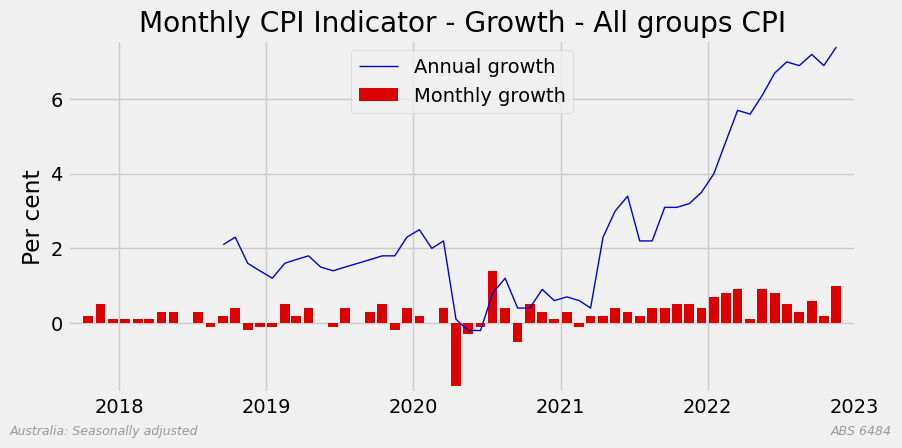

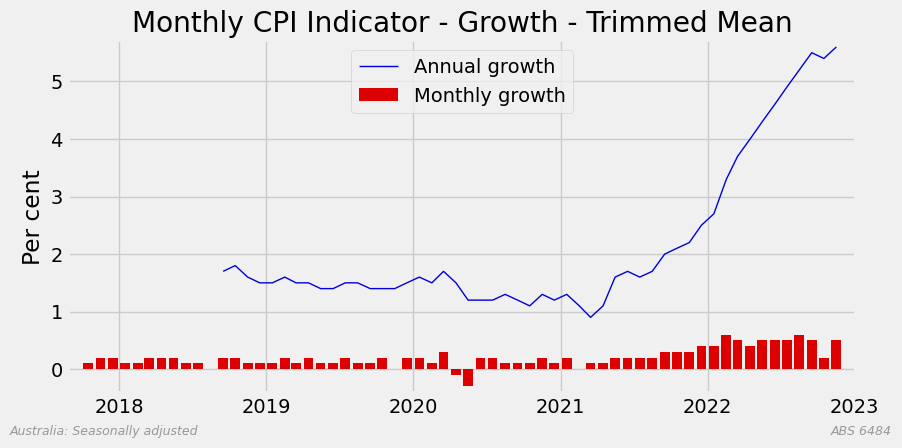

In [9]:
series_type = 'Seasonally Adjusted'
change = 'Percentage Change'
annual = 'Year'
monthly = 'Period'

for series_name in ['All groups CPI', 'Trimmed Mean']:
    data = []
    for period in annual, monthly:
        item = meta[
            (meta['Series Type'] == series_type)
            & meta['Data Item Description'].str.contains(period)
            & meta['Data Item Description'].str.contains(change)
            & meta['Data Item Description'].str.contains(series_name)
        ]
        assert len(item) == 1
        table = item['Table'].values[0]
        series_id = item['Series ID'].values[0]
        data.append(abs_dict[table][series_id])

    plot_growth2(
        data[0], data[1], 
        f'Monthly CPI Indicator - Growth - {series_name}', 
        None, '', CHART_DIR,
        rfooter=f'{source}',
        lfooter=f'Australia: {series_type.capitalize()}',
        ppy=12, # four periods per year
        show=True
    )

### Plot - growth charts - line charts

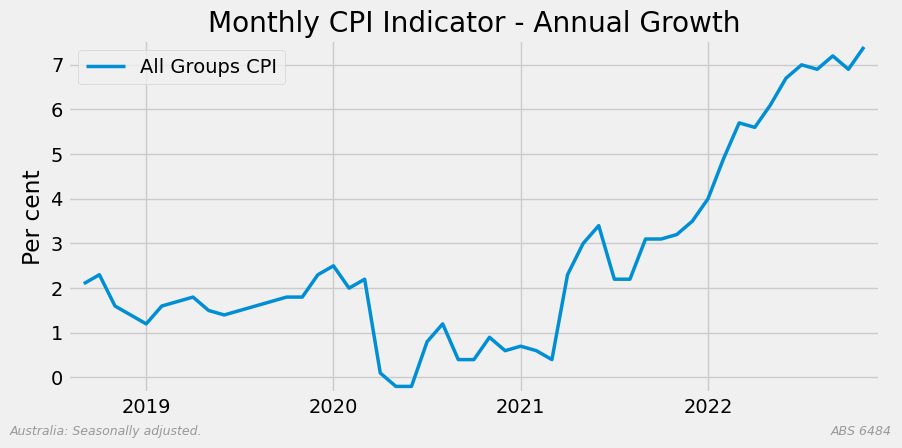

In [10]:
selectors = {
    # chart label
    'All Groups CPI': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'All groups CPI'],
        ['Data Item Description', 'Previous Year'],
        ['Data Item Description', 'Percentage Change'],
    ],
}

plot = plot_constructor(selectors)

ax = plot.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annual Growth'
tag = 'Annual Change'
series_type = 'Seasonally adjusted.'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

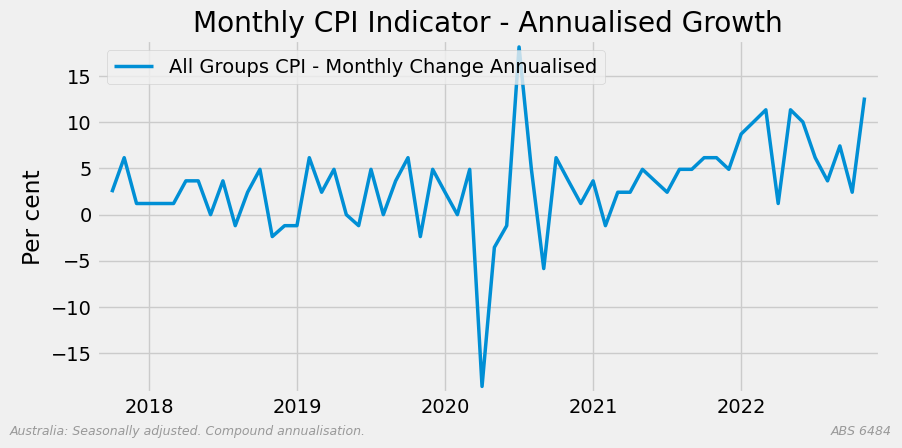

In [11]:
selectors = {
    # chart label
    'All Groups CPI - Monthly Change Annualised': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'All groups CPI'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
}
plot_m = annualise_percentages(plot_constructor(selectors))

ax = plot_m.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annualised Growth'
tag = 'Monthly Change Annualised'
series_type = 'Seasonally adjusted. Compound annualisation.'
ax.legend(loc='upper left')
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )


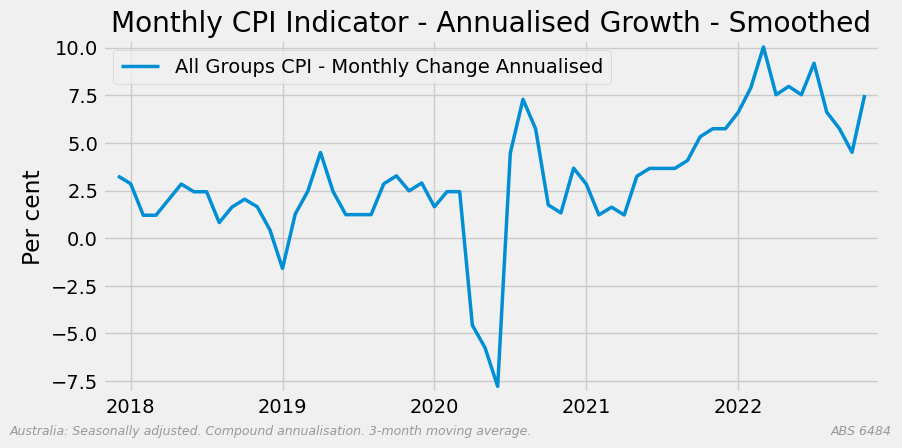

In [12]:
roll = 3 # moving average period
plot_ma = plot_m.rolling(roll).mean()
#c0 = {plot_ma.columns[0]: f'{plot_ma.columns[0]} - {roll}Mo MA'}
#plot_ma = plot_ma.rename(columns=c0)
ax = plot_ma.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annualised Growth - Smoothed'
tag = f'Monthly Change Annualised ({roll}-Mo MA)'
series_type = f'Seasonally adjusted. Compound annualisation. {roll}-month moving average.'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

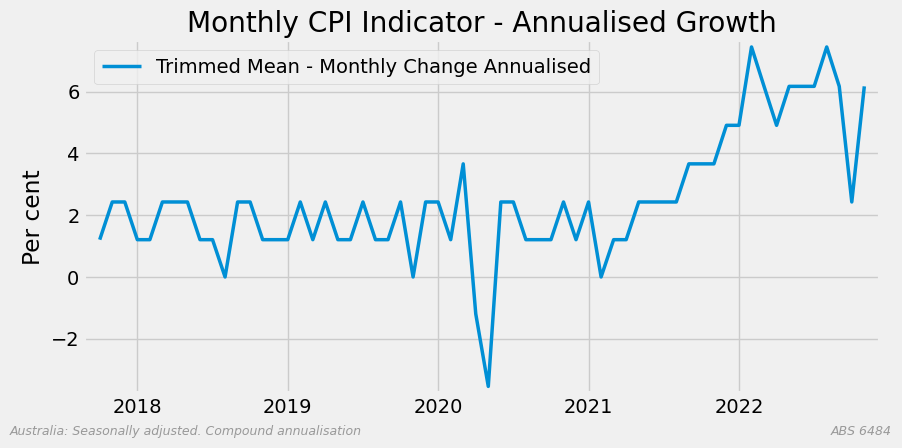

In [13]:
selectors = {
    # chart label
    'Trimmed Mean - Monthly Change Annualised': 
    [
        ['Series Type', 'Seasonally Adjusted'],
        ['Data Item Description', 'Trimmed Mean'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
}
plot_tm = annualise_percentages(plot_constructor(selectors))
ax = plot_tm.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annualised Growth'
tag = 'Trimmed Mean Monthly Change Annualised'
series_type = 'Seasonally adjusted. Compound annualisation'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

### Selected sub items

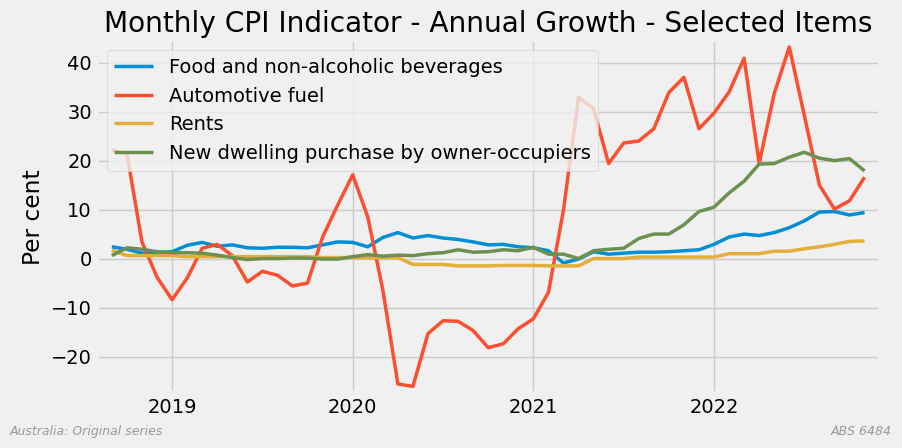

In [14]:
selectors = {
    # chart label
    'Food and non-alcoholic beverages': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'Food and non-alcoholic beverages'],
        ['Data Item Description', 'Percentage Change'],
    ],
    'Automotive fuel': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'Automotive fuel'],
        ['Data Item Description', 'Previous Year'],
        ['Data Item Description', 'Percentage Change'],
    ],
    'Rents': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'Rents'],
        ['Data Item Description', 'Previous Year'],
        ['Data Item Description', 'Percentage Change'],
    ],
    'New dwelling purchase by owner-occupiers': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'New dwelling purchase'],
        ['Data Item Description', 'Previous Year'],
        ['Data Item Description', 'Percentage Change'],
    ],
}
plot_select = plot_constructor(selectors)

ax = plot_select.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annual Growth - Selected Items'
tag = ''
series_type = 'Original series'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

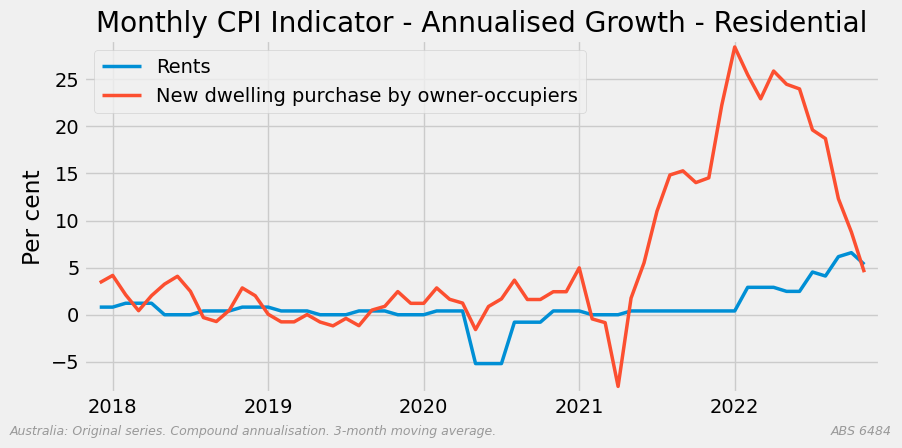

In [15]:
selectors = {
    # chart label
    'Rents': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'Rents'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
    'New dwelling purchase by owner-occupiers': 
    [
        ['Series Type', 'Original'],
        ['Data Item Description', 'New dwelling purchase'],
        ['Data Item Description', 'Previous Period'],
        ['Data Item Description', 'Percentage Change'],
    ],
}

roll = 3 # moving average frame

plot_resi = annualise_percentages(plot_constructor(selectors)).rolling(roll).mean()

ax = plot_resi.dropna().plot(lw=2.5)
title = f'Monthly CPI Indicator - Annualised Growth - Residential'
tag = ''
series_type = f'Original series. Compound annualisation. {roll}-month moving average.'
finalise_plot(
            ax, title, 
            'Per cent', 
            tag, CHART_DIR,
            rfooter=f'{source}',
            lfooter=f'Australia: {series_type}',
            show=True,
        )

## Finished

In [16]:
print('Done')

Done
